# BBC News NLP
An analysis of BBC News articles, using NLP. [Data is available here](http://mlg.ucd.ie/datasets/bbc.html).

Objectives:
* Use the full text dataset and classify each existing category into sub-categories: 
    * Breakdown ‘Business’ into stock market, company news, mergers and acquisitions etc. 
    * Breakdown ‘Entertainment’ into cinema, theatre, music, literature, personality etc. 
    * Breakdown ‘Sports’ into the type of sport: cricket, football, Olympics etc. 
    * Please create as many categories as you feel are appropriate. 
* Identify documents and extract the named entities for media personalities, clearly identifying their jobs (e.g. Politicians, TV/Film Personalities, Musicians)
* Extract summaries of anything that took place or is/was scheduled to take place in April.

In [1]:
# Load Libraries
import pandas as pd
import re
import nltk
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer as WNL
from nltk.corpus import wordnet
from string import punctuation
stopwords_list = stopwords.words('english')
stopwords_list = [*stopwords_list, *list(punctuation), *['``', "''"]]
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer


In [3]:
# Load the files
parent_folder = "C:\\Users\\User\\Documents\\Projects\\BBC_News_NLP\\Data\\bbc"

category_folders = []
for folder in os.listdir(parent_folder):
    path = os.path.join(parent_folder, folder)

    if os.path.isdir(path):
        category_folders.append(path)

articles_list = []
for category in category_folders:
    for article in os.listdir(category):
        if article.endswith(".txt") and not article.startswith("README"):
            article_path = os.path.join(category, article)
            try: 
                with open(article_path, "r") as file:
                    article_text = file.read()
                    articles_list.append({"text" : article_text, "category" : os.path.relpath(category, parent_folder)})
            except: 
                print(f"Could not load {article_path}")

articles = pd.DataFrame(articles_list)

print(f"{len(articles)} articles loaded")
articles.head()

2225 articles loaded


,text,category
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business


In [5]:
# Check for and remove any duplicates
print(articles[articles.duplicated()].head())
print(f"{len(articles[articles.duplicated()])} duplicated rows") #98 duplicate rows

articles = articles.drop_duplicates()

                                                  text  category
239  Economy 'strong' in election year\n\nUK busine...  business
252  Jobs growth still slow in the US\n\nThe US cre...  business
332  Troubled Marsh under SEC scrutiny\n\nThe US st...  business
355  S Korea spending boost to economy\n\nSouth Kor...  business
370  Singapore growth at 8.1% in 2004\n\nSingapore'...  business
98 duplicated rows


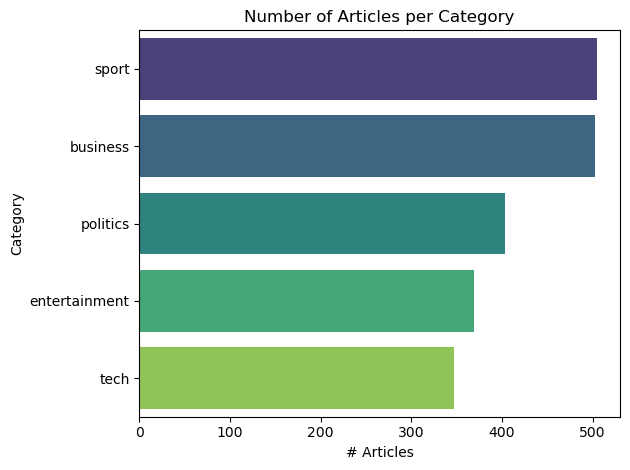

In [7]:
# Visualise the number of articles per category:

sns.countplot(data=articles, y='category', order=articles['category'].value_counts().index, palette='viridis')
plt.title("Number of Articles per Category")
plt.xlabel("# Articles")
plt.ylabel("Category")
plt.tight_layout()
plt.show()

## Process the data

Define a function to pre-process sentences using tokenisation, POS-tagging, lemmatisation, and removing stop-words, and a function to convert POS-tags to the format used by WNL:

In [28]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN 

def preprocess_sentence(input_text):
    tagged_text = []
    for word, tag in pos_tag(word_tokenize(input_text)):
        tagged_text.append((word, get_wordnet_pos(tag)))
        
    lemma_text = [WNL().lemmatize(word.lower(), pos=tag) for word, tag in tagged_text]
    processed_text = [word for word in lemma_text if word not in stopwords_list and not word.isdigit()]
    return processed_text

In [30]:
articles["cleaned_text"] = articles["text".apply(lambda x: " ".join(preprocess_sentence(x)))
articles.head()

,text,category,cleaned_text
0,Ad sales boost Time Warner profit\n\nQuarterly...,business,ad sale boost time warner profit quarterly pro...
1,Dollar gains on Greenspan speech\n\nThe dollar...,business,dollar gain greenspan speech dollar hit high l...
2,Yukos unit buyer faces loan claim\n\nThe owner...,business,yukos unit buyer face loan claim owner embattl...
3,High fuel prices hit BA's profits\n\nBritish A...,business,high fuel price hit ba 's profit british airwa...
4,Pernod takeover talk lifts Domecq\n\nShares in...,business,pernod takeover talk lift domecq share uk drin...


We can also use TextRank summarisation to simplify the articles. TextRank has been chosen as it balances a greater complexity than traditional summarisation against the much higher computational costs of abstract summarisation (and the risks associated with generative extraction by the latter).

In [56]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.text_rank import TextRankSummarizer

text_rank_summarizer = TextRankSummarizer()
def textRank_summary(text, n=4):
    try:
        parser = PlaintextParser.from_string(text, Tokenizer("english"))
        summary = text_rank_summarizer(parser.document, sentences_count=n)
        return " ".join(str(sentence) for sentence in summary)
    except Exception as e:
        return ""

articles["textRank_summary"] = articles['text'].apply(textRank_summary)

articles.head()

,text,category,cleaned_text,textRank_summary
0,Ad sales boost Time Warner profit\n\nQuarterly...,business,ad sale boost time warner profit quarterly pro...,It hopes to increase subscribers by offering t...
1,Dollar gains on Greenspan speech\n\nThe dollar...,business,dollar gain greenspan speech dollar hit high l...,The dollar has hit its highest level against t...
2,Yukos unit buyer faces loan claim\n\nThe owner...,business,yukos unit buyer face loan claim owner embattl...,The owners of embattled Russian oil giant Yuko...
3,High fuel prices hit BA's profits\n\nBritish A...,business,high fuel price hit ba 's profit british airwa...,To help offset the increased price of aviation...
4,Pernod takeover talk lifts Domecq\n\nShares in...,business,pernod takeover talk lift domecq share uk drin...,Shares in UK drinks and food firm Allied Domec...


## Subject Classification
As this data is unlabelled, unsupervised learning techniques will be used to attempt to classify the subjects within each broader category.

Let's focus on just the sports articles:

In [67]:
sports_articles = articles[articles["category"] == "sport"].copy()

sports_articles.head()

,text,category,cleaned_text,textRank_summary
1313,Claxton hunting first major medal\n\nBritish h...,sport,claxton hunt first major medal british hurdler...,The 25-year-old has already smashed the Britis...
1314,O'Sullivan could run in Worlds\n\nSonia O'Sull...,sport,o'sullivan could run world sonia o'sullivan in...,Athletics Ireland have hinted that the 35-year...
1315,Greene sets sights on world title\n\nMaurice G...,sport,greene set sight world title maurice greene ai...,"""I believe that's what put me in lane seven in..."
1316,IAAF launches fight against drugs\n\nThe IAAF ...,sport,iaaf launch fight drug iaaf athletics world go...,The IAAF - athletics' world governing body - h...
1317,"Dibaba breaks 5,000m world record\n\nEthiopia'...",sport,"dibaba break 5,000m world record ethiopia 's t...",Ethiopia's Tirunesh Dibaba set a new world rec...


### Topic Modelling

There are three broad approaches, topic modelling (such as NMF and LDA), rule-based labelling, or clustering.
* Topic modelling aims to group the articles into similar 'hidden' topics, and returns key-words so they can be labelled.
* Rule-based labelling searches for pre-defined labels, which is fast but requires effective and comprehensive domain knowledge.
* Clustering vectorises each article and then groups based on similarity. This can be fast, but also less interpretable than others.
* Alternatively:
    * Zero-shot classification can also be used, which uses an already trained model to assign probabilistic labels to articles. However this can lack nuance as it is trained on external datasets, and can still be computationally expensive.
    * If enough articles can be labelled, it may also be possible to use supervised machine learning 



In [ ]:
# Vectorise the article text (note that we could use "analyzer = preprocess_sentence" to use the custom function)
count_vector = CountVectorizer(max_df=0.9, min_df=0.05)
vectorised = count_vector.fit_transform(sports_articles["cleaned_text"])

In [13]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=6, random_state=50)
W = nmf.fit_transform(vectorised)
H = nmf.components_

In [14]:
def get_top_keywords(model, feature_names, n_top_words=10):
    keywords = []
    for topic_idx, topic in enumerate(model.components_):
        top_features = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        keywords.append(top_features)
    return keywords

feature_names = count_vector.get_feature_names_out()
topic_keywords = get_top_keywords(nmf, feature_names)
for i, topic in enumerate(topic_keywords):
    print(f"Topic {i}: {', '.join(topic)}")

sports_articles["cluster"] = W.argmax(axis=1)

Topic 0: win, play, say, open, year, match, first, last, u, beat
Topic 1: say, would, n't, club, liverpool, player, go, think, want, get
Topic 2: world, win, second, olympic, best, race, european, title, champion, indoor
Topic 3: new, zealand, wale, game, win, first, rugby, team, tour, side
Topic 4: game, point, break, set, hold, minute, first, serve, take, back
Topic 5: england, ireland, six, france, nation, robinson, wale, coach, side, rugby


In [15]:
topics = {
    0: "golf",
    1: "football",
    2: "olympics",
    3: "rugby",
    4: "tennis",
    5: "rugby2"
}
sports_articles["sub_category"] = sports_articles["cluster"].map(topics)

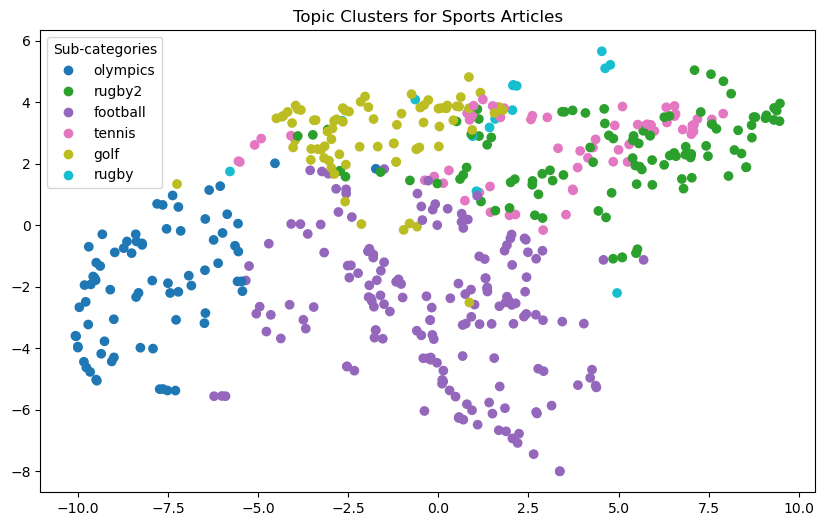

In [16]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

subcat_to_num = {label: idx for idx, label in enumerate(sports_articles['sub_category'].unique())}
colors = sports_articles['sub_category'].map(subcat_to_num)

tsne = TSNE(n_components=3, random_state=50)
X_tsne = tsne.fit_transform(W)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=colors, cmap='tab10')
plt.title('Topic Clusters for Sports Articles')

# Add legend
handles, labels = scatter.legend_elements()
labels = [k for k, v in subcat_to_num.items()]  # readable labels
plt.legend(handles, labels, title="Sub-categories")
plt.show()

In [17]:
import spacy
nlp = spacy.load("en_core_web_sm")

def extract_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

# Example
sample = sports_articles['text'].iloc[0]
print(extract_entities(sample))

[('first', 'ORDINAL'), ('British', 'NORP'), ('Sarah Claxton', 'PERSON'), ('first', 'ORDINAL'), ("next month's", 'DATE'), ('European Indoor Championships', 'ORG'), ('Madrid', 'GPE'), ('25-year-old', 'DATE'), ('British', 'NORP'), ('60', 'CARDINAL'), ('this season', 'DATE'), ('7.96 seconds', 'TIME'), ('Claxton', 'ORG'), ('Claxton', 'PERSON'), ('60', 'CARDINAL'), ('the past three years', 'DATE'), ('Scotland', 'GPE'), ('fifth', 'ORDINAL'), ('this year', 'DATE'), ("last week's", 'DATE'), ('Birmingham Grand Prix', 'FAC'), ('Claxton', 'GPE'), ('European', 'NORP'), ('Russian Irina Shevchenko', 'NORP'), ('sixth', 'ORDINAL'), ('first', 'ORDINAL'), ('Claxton', 'ORG'), ('previous seasons', 'DATE'), ('25-year-old', 'DATE'), ('Colchester', 'ORG'), ('London', 'GPE'), ('Claxton', 'ORG'), ('the European Indoors', 'ORG'), ('5-6 March', 'DATE')]


In [18]:
from spacy.matcher import PhraseMatcher

sports = ['cricket', 'football', 'rugby', 'tennis', 'nba', 'formula one', 'olympics', 'golf', 'boxing']
patterns = [nlp.make_doc(sport) for sport in sports]
matcher = PhraseMatcher(nlp.vocab)
matcher.add("SPORTS", patterns)

def match_sport(text):
    doc = nlp(text.lower())
    matches = matcher(doc)
    matched_sports = list(set([doc[start:end].text for match_id, start, end in matches]))
    return matched_sports

# Apply to dataset
sports_articles['matched_sports'] = sports_articles['text'].apply(match_sport)

In [19]:
print(sports_articles['matched_sports'])

1313          []
1314          []
1315          []
1316          []
1317          []
          ...   
1819          []
1820          []
1821          []
1822    [tennis]
1823          []
Name: matched_sports, Length: 505, dtype: object


In [20]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=6, random_state=42)
W = nmf.fit_transform(vectorised)  # W: document-topic matrix
H = nmf.components_       # H: topic-term matrix

# Assign each article to the topic with the highest score
sports_articles['nmf_topic'] = W.argmax(axis=1)


In [21]:
import spacy
from spacy.matcher import PhraseMatcher

nlp = spacy.load("en_core_web_sm")

# Define sports terms
sports = ['cricket', 'football', 'rugby', 'tennis', 'nba', 'formula one', 'f1', 'olympics', 'golf', 'boxing']
patterns = [nlp.make_doc(sport) for sport in sports]
matcher = PhraseMatcher(nlp.vocab)
matcher.add("SPORTS", patterns)

def detect_sport(text):
    doc = nlp(text.lower())
    matches = matcher(doc)
    matched = list(set([doc[start:end].text for _, start, end in matches]))
    return matched[0] if matched else 'unknown'

# Apply it
sports_articles['ner_sport'] = sports_articles['text'].apply(detect_sport)


In [22]:
pd.crosstab(sports_articles['nmf_topic'], sports_articles['ner_sport'])

ner_sport,boxing,cricket,football,golf,olympics,rugby,tennis,unknown
nmf_topic,,,,,,,,
0,0,0,4,0,0,1,25,47
1,2,0,52,0,12,11,10,81
2,0,0,2,0,21,0,0,51
3,0,1,5,0,0,5,0,4
4,0,0,8,0,0,4,4,49
5,0,1,9,1,0,37,1,57


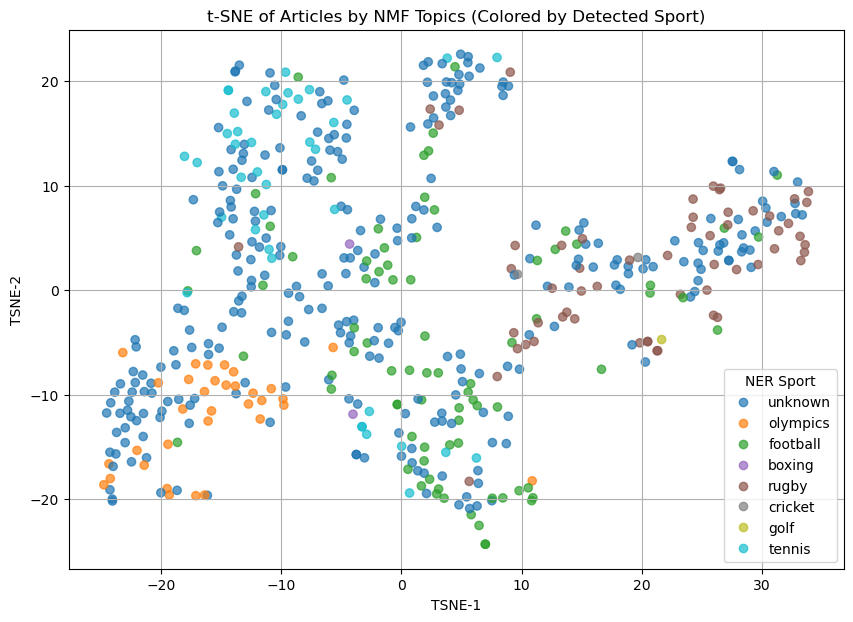

In [23]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Run t-SNE on topic embeddings
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(W)

# Map sports to colours
sport_to_num = {sport: i for i, sport in enumerate(sports_articles['ner_sport'].unique())}
color_vals = sports_articles['ner_sport'].map(sport_to_num)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=color_vals, cmap='tab10', alpha=0.7)
plt.title("t-SNE of Articles by NMF Topics (Colored by Detected Sport)")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")

# Add legend
handles, _ = scatter.legend_elements()
labels = list(sport_to_num.keys())
plt.legend(handles, labels, title="NER Sport")
plt.grid(True)
plt.show()


In [24]:
def get_top_words(H, feature_names, top_n=8):
    topic_words = []
    for topic in H:
        top_idx = topic.argsort()[:-top_n - 1:-1]
        topic_words.append([feature_names[i] for i in top_idx])
    return topic_words

top_words = get_top_words(H, count_vector.get_feature_names_out())

# Print each topic
for i, words in enumerate(top_words):
    print(f"Topic {i}: {', '.join(words)}")


Topic 0: win, play, say, open, year, match, first, last
Topic 1: say, would, n't, club, liverpool, player, go, think
Topic 2: world, win, second, olympic, best, race, european, title
Topic 3: new, zealand, wale, game, win, first, rugby, team
Topic 4: game, point, break, set, hold, minute, first, serve
Topic 5: england, ireland, six, france, nation, robinson, wale, coach


In [94]:
# zero-shot classification
classifier = pipeline("zero-shot-classification", device = 0)
labels = ["football", "golf", "rugby", "boxing", "cricket", "olympics", "tennis", "athletics"]

classifier(sports_articles["text"].iloc[0], candidate_labels=labels)


No model was supplied, defaulted to facebook/bart-large-mnli and revision d7645e1 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


{'sequence': 'Claxton hunting first major medal\n\nBritish hurdler Sarah Claxton is confident she can win her first major medal at next month\'s European Indoor Championships in Madrid.\n\nThe 25-year-old has already smashed the British record over 60m hurdles twice this season, setting a new mark of 7.96 seconds to win the AAAs title. "I am quite confident," said Claxton. "But I take each race as it comes. "As long as I keep up my training but not do too much I think there is a chance of a medal." Claxton has won the national 60m hurdles title for the past three years but has struggled to translate her domestic success to the international stage. Now, the Scotland-born athlete owns the equal fifth-fastest time in the world this year. And at last week\'s Birmingham Grand Prix, Claxton left European medal favourite Russian Irina Shevchenko trailing in sixth spot.\n\nFor the first time, Claxton has only been preparing for a campaign over the hurdles - which could explain her leap in form

In [96]:
classified_labels = []
classification_scores = []

# Iterate through each text in the 'text' column
for text in sports_articles["text"]:
    result = classifier(text, candidate_labels=labels)

    # The result's 'labels' and 'scores' are already sorted by score (highest first)
    top_label = result['labels'][0]
    top_score = result['scores'][0]

    classified_labels.append(top_label)
    classification_scores.append(top_score)

# Add the new columns to the DataFrame
sports_articles["classification"] = classified_labels
sports_articles["score"] = classification_scores



KeyboardInterrupt



In [ ]:
from transformers import pipeline
import pandas as pd

# Assuming sports_articles is already defined and loaded
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=0)
labels = ["football", "golf", "rugby", "boxing", "cricket", "olympics", "tennis", "athletics"]

def classify_text(text):
    """
    Applies the zero-shot classification to a single text and returns
    the top label and its score.
    """
    result = classifier(text, candidate_labels=labels)
    return result['labels'][0], result['scores'][0]

# Apply the function to the 'text' column
# .apply() with a lambda or a function will return a Series of tuples
classification_results = sports_articles["text"].apply(classify_text)

# Unpack the tuples into two new columns
sports_articles["classification"] = classification_results.apply(lambda x: x[0])
sports_articles["score"] = classification_results.apply(lambda x: x[1])

print(sports_articles.head())

Device set to use cpu


In [ ]:
# Summarise first:
